# Burgers' Equation Solution using PINNs

In [11]:
# %pip install torch
# %pip install matplotlib
# %pip install tqdm


In [12]:
import torch
from torch import nn
from torch import optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

import math
import numpy as np

import matplotlib.pyplot as plt
import tqdm
from IPython.display import clear_output


### Neural Network structure

In [13]:
class PINN(nn.Module):
  def __init__(self, fc_list, viscosity):
    super().__init__()

    self.activation = nn.Tanh()

    self.l = viscosity

    self.loss_function = nn.MSELoss()

    self.fc_list = fc_list # first, last = input_size, output_size
    self.network = nn.ModuleList([nn.Linear(fc_list[i], fc_list[i + 1]) for i in range(len(fc_list) - 1)])

    for i in range(len(self.fc_list)-1):
      nn.init.kaiming_normal_(self.network[i].weight.data)

  def forward(self, x):
    output = x

    for i in range(len(self.fc_list) - 2):
      output = self.network[i](output)
      output = self.activation(output)

    return self.network[-1](output)

  # t = 0
  def error_initial(self, state, u_expected):
    return self.loss_function(self.forward(state), u_expected)

  # x = ±1
  def error_border(self, state, u_expected):
    return self.loss_function(self.forward(state), u_expected)

  # ∂t*u + u*∂x*u - λ*∂xx*u
  def error_pde(self, state):
    state_ = state.clone()

    state_.requires_grad = True

    u = self.forward(state_)

    dx_dt = torch.autograd.grad(
      u, state_,
      torch.ones([state_.shape[0],1]),
      retain_graph=True, create_graph=True
    )[0]
    dxx_dtt = torch.autograd.grad(
      dx_dt, state_,
      torch.ones(state_.shape),
      create_graph=True
    )[0]

    u_t = dx_dt[:,[1]]
    u_x = dx_dt[:,[0]]
    u_xx = dxx_dtt[:,[0]]

    residual = u_t + u * u_x - self.l * u_xx

    return self.loss_function(residual, torch.zeros_like(residual))

  def error_total(self, state_i, u_i, state_b, u_b, state_a):
    return self.error_initial(state_i, u_i) + self.error_border(state_b, u_b) + self.error_pde(state_a)

### Network construction

In [14]:
EPOCHS = 10000
LEARNING_RATE = 0.0015
GAMMA = 0.9999
BATCH_SIZE = 2500

FC_LAYERS = [2, 8, 32, 64, 64, 32, 16, 1]

VISCOSITY = 0.01 / math.pi

solver = PINN(FC_LAYERS, VISCOSITY)


### Visualizations

In [15]:
def plot_stats(train_loss: list[float], valid_loss: list[float]):
  plt.figure(figsize=(16, 8))

  plt.plot(train_loss, label='Training loss')
  plt.plot(valid_loss, label='Validation loss')

  plt.legend()

  plt.ylabel("Loss")
  plt.xlabel("Epoch")

  plt.show()

def plot_fun(x):
  u_tensor = solver(x)
  u = u_tensor.squeeze().detach().numpy()
  return u

def plot_t():
  x = np.arange(-1, 1.01, 0.01)
  x_t = torch.Tensor(x)
  inputs1 = torch.cat([x_t.view(201, 1), torch.zeros(x_t.size()).view(201, 1)], dim=1)
  inputs2 = torch.cat([x_t.view(201, 1), torch.full_like(x_t, 0.25).view(201, 1)], dim=1)
  inputs3 = torch.cat([x_t.view(201, 1), torch.full_like(x_t, 0.5).view(201, 1)], dim=1)
  inputs4 = torch.cat([x_t.view(201, 1), torch.full_like(x_t, 0.75).view(201, 1)], dim=1)

  u1 = plot_fun(inputs1)
  u2 = plot_fun(inputs2)
  u3 = plot_fun(inputs3)
  u4 = plot_fun(inputs4)

  plt.plot(x, u1, marker='', linestyle='solid', color='#fd8a8a')
  plt.plot(x, u2, marker='', linestyle='solid', color='#ffcbcb')
  plt.plot(x, u3, marker='', linestyle='solid', color='#a8d1d1')
  plt.plot(x, u4, marker='', linestyle='solid', color='#9ea1d4')

  plt.xlabel('x')
  plt.ylabel('u')

  plt.show()


### Dataset generation

In [16]:
class CustomDataset(Dataset):
  def __init__(self, num_samples):
    super().__init__()

    self.num_samples = num_samples

    num_random = int(num_samples)
    num_border = int(num_samples)
    num_beginning = int(num_samples)

    self.random_t = torch.rand((num_random, 1))
    self.random_x = torch.rand((num_random, 1)) * 2 - 1
    self.random_all = torch.cat([self.random_x, self.random_t], dim=1)

    self.border_t = torch.rand((num_border, 1))
    self.border_x = torch.randint(0, 2, (num_border, 1), dtype=torch.float32) * 2 - 1
    self.border_all = torch.cat([self.border_x, self.border_t], dim=1)

    self.beginning_t = torch.zeros(num_beginning, 1)
    self.beginning_x = torch.rand((num_beginning, 1)) * 2 - 1
    self.beginning_all = torch.cat([self.beginning_x, self.beginning_t], dim=1)

  def __len__(self):
    return self.num_samples

  def __getitem__(self, item):
    return self.category_3[item], self.category_2[item], self.category_1[item]

dataset = CustomDataset(50000)

training_dataset, validation_dataset = random_split(dataset,
  (int(len(dataset) * 0.95), len(dataset) -  int(len(dataset) * 0.95)),
  generator=torch.Generator().manual_seed(238)
)

training_loader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)


False
False
False


### Network training

In [17]:
def gen_u(t_i, t_b):
  return (-math.pi * t_i[:, 0].clone().detach()).sin().unsqueeze(1), torch.zeros(t_b.size(0), 1)


In [18]:
def train_batch(model, loader_i, loader_b, loader_a, optimizer):
  correct_i, correct_b = gen_u(loader_i, loader_b)

  loss = model.error_total(loader_i, correct_i, loader_b, correct_b, loader_a)

  optimizer.zero_grad()

  loss.backward(retain_graph=True)

  optimizer.step()

  return loss.item()

def validate_batch(model, loader_i, loader_b, loader_a):
  correct_i, correct_b = gen_u(loader_i, loader_b)

  loss = model.error_total(loader_i, correct_i, loader_b, correct_b, loader_a)

  return loss.item()


In [19]:
def train(model, train_loader, valid_loader, optimizer, scheduler):
  training_loss_history, validation_loss_history = [], []

  for epoch in range(EPOCHS):
    training_loss = 0
    validation_loss = 0
    training_cnt = 0
    validation_cnt = 0

    for i, (t_i, t_b, t_a) in enumerate(tqdm.tqdm(train_loader)):
      training_loss += train_batch(model, t_i, t_b, t_a, optimizer)
      training_cnt += 1

    for i, (t_i, t_b, t_a) in enumerate(tqdm.tqdm(valid_loader)):
      validation_loss += validate_batch(model, t_i, t_b, t_a)
      validation_cnt += 1

    training_loss_history.append(training_loss / training_cnt)
    validation_loss_history.append(validation_loss / validation_cnt)

    if epoch % 10 == 0:
      clear_output(wait=True)
      plot_stats(training_loss_history, validation_loss_history)
      plot_t()
      scheduler.step()


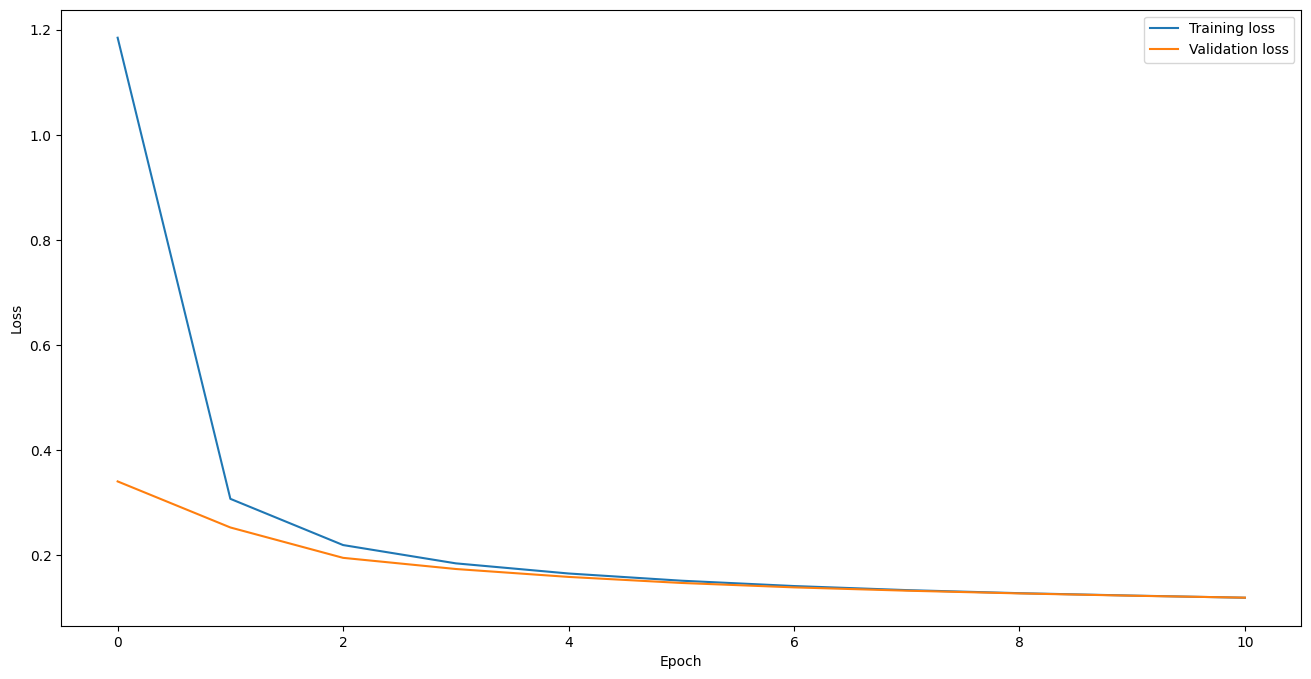

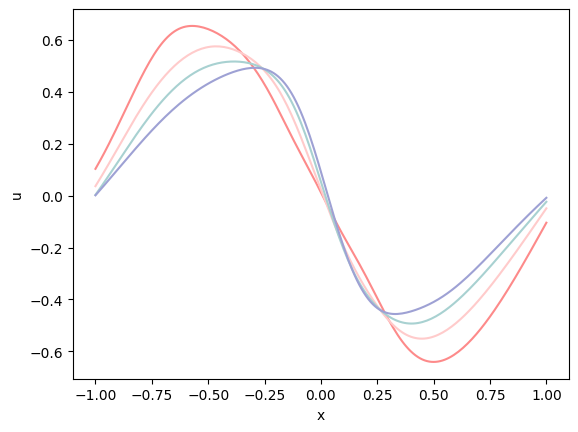

 79%|███████▉  | 15/19 [00:00<00:00, 53.31it/s]


KeyboardInterrupt: 

In [20]:
optimizer = optim.Adam(solver.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)

train(solver, training_loader, validation_loader, optimizer, scheduler)


tensor(0.0028, grad_fn=<MseLossBackward0>)
